In [1]:
#import libs
import sys,os
import numpy as np

os.chdir(r'G:\My Drive\Documents\PhD\Modelling\_RiceBall')
from ricepaper.material import NodeSet
from ricepaper import RicePaper
from ricepaper.utils import *

import matplotlib.pyplot as plt

In [2]:
#define a material
mat = NodeSet("volcano",[30,25,20], #radii
                         2500, #densities (applied to all radii)
                         6.96e9, #young's modulus (applied to all radii)
                         0.2) #poisson ratio (applied to all radii)
mat.setFriction(0.3, #friction coefficient
                2.5e6) #2.5 MPa cohesion
mat.setBonding( 5e9, #normal stiffness (Pa)
                5e9, #shear stiffness (Pa)
                5e6, #tensile strength (Pa)
                10e6) #shear strength (Pa)

Once node types have been defined we can fill a domain with this "material" by gravity deposition. This can be used to build both conical piles or fill an entire domain:

In [3]:
#generate a pile
R = mat.gravityDeposit(750,1500,base=3000, stepSize=200, walltype=3,suppress=True)

Generating 125 particles in layer 0
Generating 125 particles in layer 1
Generating 125 particles in layer 2
Generating 125 particles in layer 3
Average kinetic energy = 1.111552E+09
Average kinetic energy = 2.164960E+08
Average kinetic energy = 3.161890E+07
Average kinetic energy = 5.265886E+06
Average kinetic energy = 1.320748E+06
Average kinetic energy = 1.716490E-03
Model equilibrated


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


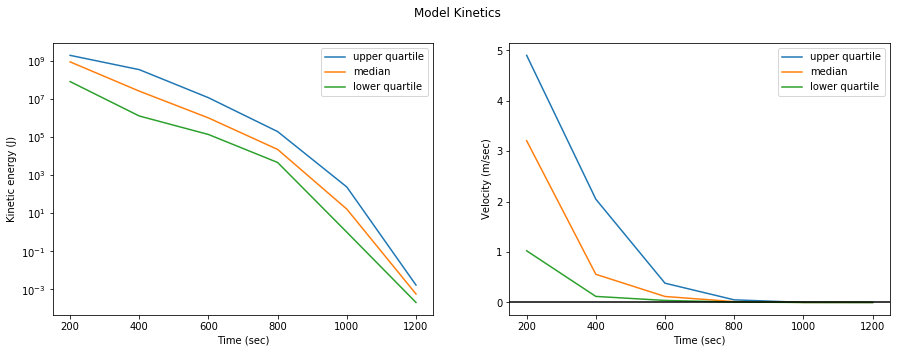

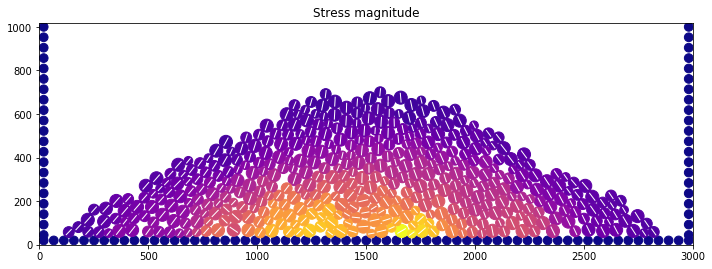

In [4]:
#get steps
steps = list(range(1,R.file+1))

#plot equilibration curves
fig,ax = R.plotKinetics(steps)

#plot final model
m = R.loadLastOutput()
m.averageAttr("stress",n = 5)
fig,ax = m.plotAttr("stress",ignoreFixed=False,title="Stress magnitude")

In [5]:
#generate a gravity settled domain
R = mat.gravityDeposit(1000,1000,walltype=3,suppress=True)

Generating 111 particles in layer 0
Generating 111 particles in layer 1
Generating 111 particles in layer 2
Generating 111 particles in layer 3
Average kinetic energy = 1.616151E+09
Average kinetic energy = 9.764887E+07
Average kinetic energy = 1.689939E-03
Model equilibrated


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


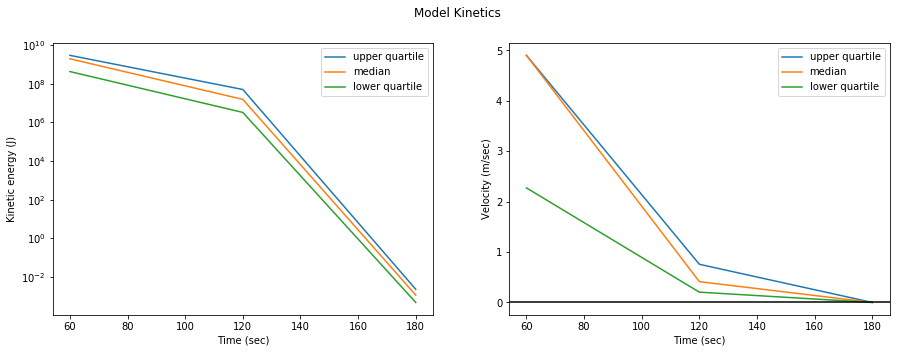

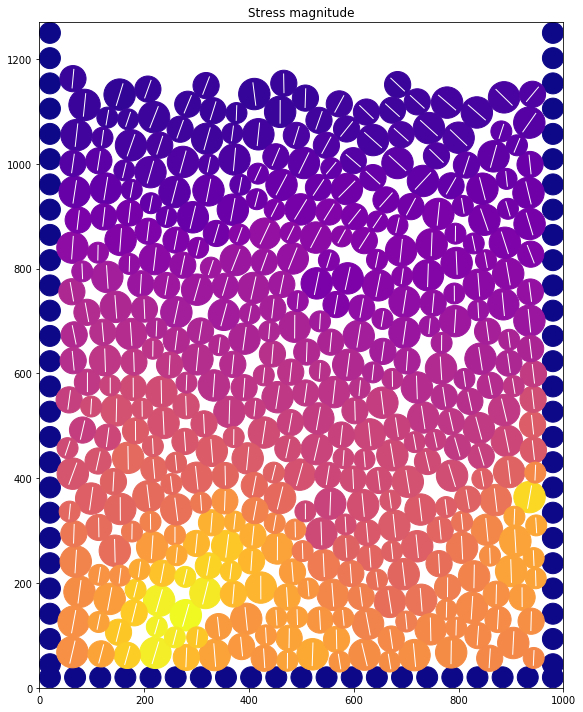

In [6]:
#get steps
steps = list(range(1,R.file+1))

#plot equilibration curves
fig,ax = R.plotKinetics(steps)

#plot model
m = R.loadLastOutput()
m.averageAttr("stress",n = 5)
fig,ax = m.plotAttr("stress",ignoreFixed=False,figSize=(5,7),title="Stress magnitude")

In [7]:
"""
Do an unconfined compression test to measure the elastic properties and compressive strength of this material

**Arguments**:
    -lower = the height of the base of the domain to compress
    -upper = the height of the top of the domain to compress
    -velocity = the y-velocity of the upper plate (lower plate velocity = 0). 
**Keywords**:
    -tStep = the timestep to use for the simulation. Default is 0.005 seconds. 
    -stepSize = the time (in seconds) to run the model for before writing output. Default is 10.
    -nSteps = the number of steps to run the model for. Default is 10. 
    -verbose = True if output is printed to console. Default is true. 
    -suppress = If True, the model is not actually executed (i.e. it is assumed that output has been
               generated on a previous run. Useful for debugging quickly. Default is False. 
**Returns**:
    -stress = the average pressure on the upper domain of the shear box at each step.
    -axial_strain = the bulk axial strain at each step.
    -lateral_strain = the bulk lateral strain at each step.
    -M = list of RiceBall objects containing particle configurations at each step in the test.
"""
def compressionTest(self,lower,upper,velocity,**kwds):
    print("todo")

In [8]:
"""
Do a pure shear test to measure the bulk cohesion of this material. 

**Arguments**:
    -lower = the height of the base of the domain to shear
    -upper = the height of the top of the domain to shear
    -velocity = the velocity of the upper plate (lower plate velocity = 0). 

**Keywords**:
    -normalStress = the normal (confining) stress applied during the shear experiment. Default is 0. 
    -tStep = the timestep to use for the simulation. Default is 0.005 seconds. 
    -stepSize = the time (in seconds) to run the model for before writing output. Default is 1.
    -nSteps = the number of steps to run the model for. Default is 250. 
    -verbose = True if output is printed to console. Default is true.
    -suppress = If True, the model is not actually executed (i.e. it is assumed that output has been
               generated on a previous run. Useful for debugging quickly. Default is False. 
**Returns**:
    -stress = the average pressure on the upper domain of the shear box at each step.
    -strain = the bulk shear strain at each step.
"""
def shearTest(self,lower,upper,velocity,**kwds):
        assert self.R != None, "Please generate a material (e.g. using gravityDeposit(...)) first."
        assert upper - lower > np.max(self.radii), "Error - Lower surface must be (significantly) below upper surface..."

        #get args
        tstep = kwds.get("tstep",0.005)
        assert tstep > 1e-9 and tstep < 1, "Error - stop passing stupid timesteps..."

        verbose = kwds.get("verbose",True)
        stepSize = kwds.get("stepSize",1)
        nSteps = kwds.get("nSteps",250)
        normalStress = kwds.get("normalStress",0)

        #clone state so we don't modify it
        R2 = self.R.clone("%s/shear_test" % self.name)
        m = self.R.loadLastOutput()
        minx,maxx,miny,maxy = m.getBounds()

        #remove wall type particles
        R2.custom("**Delete walls created during gravity deposition**")
        R2.setDomain( minx, maxx, miny, maxy, 0,  self.depth )
        R2.custom("PRP 1 EROd %d\n" % self.walltype)

        #turn of gravity
        #R2.setGravity((0,0,0))
        R2.setNumericalProperties(timestep=tstep)

        #setup shear test
        R2.custom("**Setup shear test**")
        R2.custom("Wall Pos %.3f %.3f" % (upper,lower)) #set position of platens
        R2.custom("Wall Xvel %.3f 0" % (velocity)) #set shear velocity
        R2.custom("Wall Nstress %.3f" % (-normalStress)) #set normal stress
        #R2.custom("Wall Gain %.3f" % (1.0) ) #set gain of servo responsible for maintining normal stress
        #run test
        steps = []
        for i in range(nSteps):
            steps.append(R2.cycle(stepSize))
        R2.execute(suppress=kwds.get("suppress",False))

        #load steps
        M = R2.loadSteps(steps)

        #calculate shear strain at each step (from displacement)
        t = np.linspace(stepSize,stepSize*nSteps,nSteps) #number of seconds of shearing applied to each model
        strain = np.rad2deg(np.arctan((t*velocity)/(upper-lower)))

        #estimate overall shear stress at each step (from forces on fixed particles)
        stress = []
        for m in M:
            pid,F = m.getAttributes(["force"], onlyFixed=True, gravity=np.array([0,0,0])) 
            fsum = np.array([0,0,0]) #sum of all forces on contacts
            for Flist in F:
                fsum =  fsum + np.sum(Flist,axis=0)
            stress.append(-fsum / (self.width * self.depth)) #append total force divided by area over which it is applied

        #load output
        return np.array(stress),np.array(strain), M

In [9]:
#do a shear test
stress0MPa,strain0MPa,M = mat.shearTest(100,900,0.5,normalStress=0)
stress1MPa, strain1MPa, M2 = mat.shearTest(100,900,0.5,normalStress=25e6)

AttributeError: 'NodeSet' object has no attribute 'shearTest'

In [ ]:
#plot stress and strain
plt.plot(strain0MPa,stress0MPa[:,1]/1e6)
plt.plot(strain1MPa,stress1MPa[:,1]/1e6)
plt.xlabel("Shear Strain (degrees)")
plt.ylabel("Stress (MPa)")
plt.show()

In [ ]:
#plot the end of the test
M2[0].plotUnbalanced(0.1)
M2[-1].plotUnbalanced(0.1)